# Лекция №4. Прогнозирование временных рядов с помощью нейронных сетей.

### Пример №1

In [1]:
import numpy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Выборка содержит статистику кол-ва продаж автомобилей в городе Квебек по месяцам

In [2]:
sales = pd.read_csv('monthly-car-sales-in-quebec-1960.csv', sep=';', header=0, parse_dates=[0])
sales.head()

,Month,Monthly car sales in Quebec 1960-1968
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026
3,1960-04-01,14395
4,1960-05-01,14587


In [3]:
print(sales.shape)

(108, 2)


<AxesSubplot:>

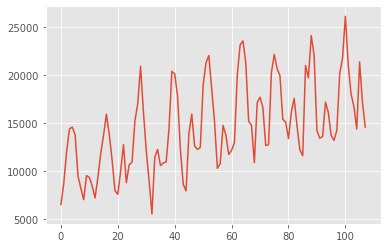

In [4]:
#  График, чтобы ответить на 4 вопроса (см. часть 1)
sales.iloc[:,1].plot()

* 1. Тренд есть, периодичность - 1 год;
* 2. Сезонность аддитивная;
* 3. Ряд все время в среднем нарастает и не меняет характер;
* 4. Значительных выбросов не наблюдается.

Чтобы обучать нейронную сеть классической архитектуры (например, полносвязную) предсказывать временные ряды, необходимо предварительно преобразовать имеющиеся данные по входные периодические вектора следующим образом:  
В данном примере мы имеем 108 чисел, соответствующих 108 месяцам продаж, и знаем, что периодичность временного ряда - 12 месяцев.  
Тогда будем строить входные вектора следующим образом:  
Берем первые 12 значений и пытаемся предсказать 13-е. Т.к. правильный ответ (т.е. реальное 13-е значение) у нас есть, можем использовать привычные метрики. Далее сдвигаем все на единицу, т.е. вектор будет состоять из чисел с 2 по 13, а предсказывать будем 14-е и т.д.

В дальнейшем, когда захотим предсказывать значения в месяца на будущее, то во входной вектор будем подставлять значения, предсказанные на предыдущем шаге. Так например, мы сначала предскажем 109-е число на основе вектора с 97 по 108, а потом для предсказания 110-го числа будем использовать имевшиеся в начальных данных числа с 98 по 108 и предсказанное на прошлом шаге 109-е число.

*Примечание*: При описанном ранее механизме формирования предсказаний с каждым новым шагом предсказаний во входном векторе будет задействоваться все больше и больше не точно известных данных, а предсказанных нейросетью на прошлых шагах, т.е. будет накапливаться ошибка, поэтому такие предсказания будут существенно неточными на временном отрезке, большем чем период временного ряда (т.е. в нашем случае - больше, чем на 12 месяцев).

In [5]:
# Преобразуем данные
sales_2 = pd.DataFrame()

for i in range(12,0,-1):
    sales_2['t-'+str(i)] = sales.iloc[:,1].shift(i)

sales_2['t'] = sales.iloc[:,1].values

print(sales_2.head(13))

      t-12    t-11     t-10      t-9      t-8      t-7      t-6      t-5  \
0      NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2      NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5      NaN     NaN      NaN      NaN      NaN      NaN      NaN   6550.0   
6      NaN     NaN      NaN      NaN      NaN      NaN   6550.0   8728.0   
7      NaN     NaN      NaN      NaN      NaN   6550.0   8728.0  12026.0   
8      NaN     NaN      NaN      NaN   6550.0   8728.0  12026.0  14395.0   
9      NaN     NaN      NaN   6550.0   8728.0  12026.0  14395.0  14587.0   
10     NaN     NaN   6550.0   8728.0  12026.0  14395.0  14587.0  13791.0   
11     NaN  6550.0   8728.0  12026.0  14395.0  14587.0  13791.0   9498.0   
12  6550.0  

In [6]:
#  Отрезаем первые 12 строк
sales_4 = sales_2[12:]

sales_4.head()

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
12,6550.0,8728.0,12026.0,14395.0,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237
13,8728.0,12026.0,14395.0,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237.0,9374
14,12026.0,14395.0,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237.0,9374.0,11837
15,14395.0,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237.0,9374.0,11837.0,13784
16,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237.0,9374.0,11837.0,13784.0,15926


In [7]:
#  предикторы и отклик разделяем
# Отклик - группирующая переменная -  вектор y
y = sales_4['t']
# Предикторы - таблица X
X = sales_4.drop('t', axis=1)

*Примечание*: Про разделение на обучающую и тестовую выборки:  
В типичном случае мы бы случайным образом отобрали нужное нам кол-во строк для тестовой выборки. Однако во временном ряде нам наиболее важно предсказать самые новые значения более точно, поэтому в качестве тестовой выборки логичнее выбирать наиболее новые значения и пытаться уменьшить ошибку на них.

In [8]:
#  Разделяем на обучающую и тестовую выборки
#  Тестовая - последние наблюдения
X_train = X[:91]
y_train = y[:91]
X_test  = X[91:]
y_test  = y[91:]

In [9]:
#  Сверяем размерности
print(sales_4.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(96, 13)
(91, 12)
(91,)
(5, 12)
(5,)


In [10]:
#  Преобразование pandas dataframe в numpy array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Будем уменьшать MSE, однако в качестве метрики выберем MASE (mean absolute percentage error/средняя абсолютная процентная ошибка), т.к. она интерпретируется понятнее.  
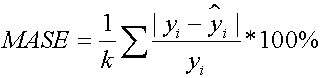

In [12]:
#  Обучение нейронной сети 

# Creating a model
model = Sequential()
model.add(Dense(8, input_dim=12, activation='relu'))
model.add(Dense(1, activation='linear'))


# Compiling model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

*Примечание*: В выходном слое **для регрессии** используется линейная активационная функция ```activation='linear'``` в отличие от **задач классификации**, в которых используется, например, ```softmax```, т.к. в регрессии мы хотим получить некоторое число, в общем случае не ограниченное интервалом [0;1].

In [13]:
# Training a model
model.fit(X_train, y_train, epochs=300, batch_size=None)

Epoch 1/300
3/3 [==============================] - 1s 2ms/step - loss: 329779040.0000 - mean_absolute_percentage_error: 127.8892
Epoch 2/300
3/3 [==============================] - 0s 2ms/step - loss: 245411616.0000 - mean_absolute_percentage_error: 110.5409
Epoch 3/300
3/3 [==============================] - 0s 2ms/step - loss: 177096272.0000 - mean_absolute_percentage_error: 93.0836
Epoch 4/300
3/3 [==============================] - 0s 3ms/step - loss: 124413952.0000 - mean_absolute_percentage_error: 76.8382
Epoch 5/300
3/3 [==============================] - 0s 2ms/step - loss: 80875520.0000 - mean_absolute_percentage_error: 60.5615
Epoch 6/300
3/3 [==============================] - 0s 2ms/step - loss: 51893280.0000 - mean_absolute_percentage_error: 47.7466
Epoch 7/300
3/3 [==============================] - 0s 2ms/step - loss: 33625320.0000 - mean_absolute_percentage_error: 37.4840
Epoch 8/300
3/3 [==============================] - 0s 2ms/step - loss: 25049702.0000 - mean_absolute_perc

3/3 [==============================] - 0s 2ms/step - loss: 11429074.0000 - mean_absolute_percentage_error: 17.8461
Epoch 66/300
3/3 [==============================] - 0s 4ms/step - loss: 11302159.0000 - mean_absolute_percentage_error: 17.7255
Epoch 67/300
3/3 [==============================] - 0s 5ms/step - loss: 11172096.0000 - mean_absolute_percentage_error: 17.5966
Epoch 68/300
3/3 [==============================] - 0s 7ms/step - loss: 11061509.0000 - mean_absolute_percentage_error: 17.5042
Epoch 69/300
3/3 [==============================] - 0s 3ms/step - loss: 10936245.0000 - mean_absolute_percentage_error: 17.4214
Epoch 70/300
3/3 [==============================] - 0s 2ms/step - loss: 10792989.0000 - mean_absolute_percentage_error: 17.3062
Epoch 71/300
3/3 [==============================] - 0s 1ms/step - loss: 10662679.0000 - mean_absolute_percentage_error: 17.2257
Epoch 72/300
3/3 [==============================] - 0s 2ms/step - loss: 10538012.0000 - mean_absolute_percentage_erro

3/3 [==============================] - 0s 2ms/step - loss: 5878723.5000 - mean_absolute_percentage_error: 12.9285
Epoch 130/300
3/3 [==============================] - 0s 2ms/step - loss: 5846582.0000 - mean_absolute_percentage_error: 12.9057
Epoch 131/300
3/3 [==============================] - 0s 2ms/step - loss: 5787214.0000 - mean_absolute_percentage_error: 12.8447
Epoch 132/300
3/3 [==============================] - 0s 2ms/step - loss: 5760527.5000 - mean_absolute_percentage_error: 12.8378
Epoch 133/300
3/3 [==============================] - 0s 2ms/step - loss: 5701911.5000 - mean_absolute_percentage_error: 12.8014
Epoch 134/300
3/3 [==============================] - 0s 2ms/step - loss: 5660032.5000 - mean_absolute_percentage_error: 12.7539
Epoch 135/300
3/3 [==============================] - 0s 4ms/step - loss: 5622870.0000 - mean_absolute_percentage_error: 12.6920
Epoch 136/300
3/3 [==============================] - 0s 5ms/step - loss: 5575109.5000 - mean_absolute_percentage_error

3/3 [==============================] - 0s 2ms/step - loss: 4219952.0000 - mean_absolute_percentage_error: 11.0724
Epoch 194/300
3/3 [==============================] - 0s 2ms/step - loss: 4207402.5000 - mean_absolute_percentage_error: 11.0740
Epoch 195/300
3/3 [==============================] - 0s 1ms/step - loss: 4210336.0000 - mean_absolute_percentage_error: 11.0747
Epoch 196/300
3/3 [==============================] - 0s 2ms/step - loss: 4197649.5000 - mean_absolute_percentage_error: 11.0714
Epoch 197/300
3/3 [==============================] - 0s 3ms/step - loss: 4174572.2500 - mean_absolute_percentage_error: 11.0431
Epoch 198/300
3/3 [==============================] - 0s 2ms/step - loss: 4161943.2500 - mean_absolute_percentage_error: 11.0154
Epoch 199/300
3/3 [==============================] - ETA: 0s - loss: 3895559.0000 - mean_absolute_percentage_error: 10.303 - 0s 2ms/step - loss: 4150726.7500 - mean_absolute_percentage_error: 11.0039
Epoch 200/300
3/3 [===========================

3/3 [==============================] - 0s 4ms/step - loss: 3745109.7500 - mean_absolute_percentage_error: 10.4333
Epoch 257/300
3/3 [==============================] - 0s 4ms/step - loss: 3735434.5000 - mean_absolute_percentage_error: 10.4330
Epoch 258/300
3/3 [==============================] - 0s 2ms/step - loss: 3734635.5000 - mean_absolute_percentage_error: 10.4551
Epoch 259/300
3/3 [==============================] - 0s 2ms/step - loss: 3730742.7500 - mean_absolute_percentage_error: 10.4489
Epoch 260/300
3/3 [==============================] - 0s 2ms/step - loss: 3717538.7500 - mean_absolute_percentage_error: 10.4277
Epoch 261/300
3/3 [==============================] - 0s 3ms/step - loss: 3718659.7500 - mean_absolute_percentage_error: 10.4224
Epoch 262/300
3/3 [==============================] - 0s 2ms/step - loss: 3705618.2500 - mean_absolute_percentage_error: 10.3964
Epoch 263/300
3/3 [==============================] - 0s 2ms/step - loss: 3710059.2500 - mean_absolute_percentage_error

In [14]:
# оценка качества модели на тестовом множестве
scores = model.evaluate(X_test, y_test)
print("\nMAPE: %.2f%%" % (scores[1]))

1/1 [==============================] - 0s 164ms/step - loss: 4296063.0000 - mean_absolute_percentage_error: 11.1980

MAPE: 11.20%


*Примечание*: Т.к. здесь в тестовых данных во входных векторах **не использовались** предсказанные самой нейросетью данные, то результирующий score получился лучше, чем он будет на реальных данных.

In [15]:
# Вычисляем прогноз
predictions = model.predict(X_test)
# Вычисляем подгонку
predictions_train = model.predict(X_train)

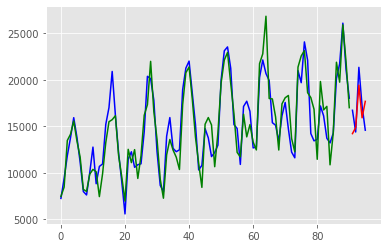

In [16]:
#   График с результатами

#   numpy.arange([start, ]stop, [step, ]dtype=None)¶

x2 = numpy.arange(0, X_train.shape[0], 1)

x3 = numpy.arange(X_train.shape[0], X_train.shape[0] + X_test.shape[0], 1)


plt.plot(x2, y_train, color='blue')

plt.plot(x2, predictions_train, color='green')

plt.plot(x3, y_test, color='blue')

plt.plot(x3, predictions, color='red')

### Пример №2

In [17]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

В качестве примера будут использоваться данные о международных пассажирских авиаперевозках в тысячах человек по месяцам с 1949 по 1960 годы.

In [18]:
# Импорт обучающей выборки
ser_g = pd.read_csv('series_g.csv', sep=';', header=0)
ser_g.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [19]:
print(ser_g.shape)

(144, 2)


<AxesSubplot:>

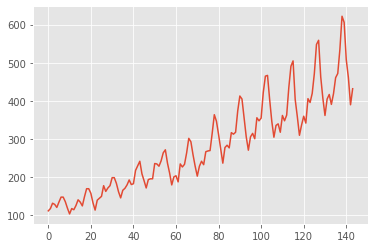

In [20]:
#  График, чтобы ответить на 4 вопроса
ser_g.iloc[:,1].plot()

* 1. Тренд есть, периодичность - 1 год;
* 2. Сезонность мультипликативная;
* 3. Ряд все время в среднем нарастает и не меняет характер;
* 4. Значительных выбросов не наблюдается.

Т.к. сезонность мультипликативная, то необходимо подавать на нейросеть логарифм от исходных данных.

In [21]:
ser_g['log_y'] = numpy.log10(ser_g['series_g'])

Text(0, 0.5, 'log10 от тысяч человек')

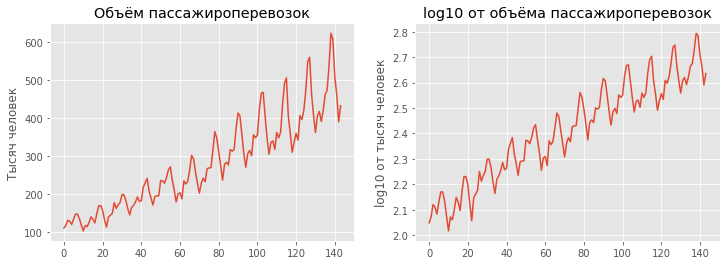

In [22]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ser_g['series_g'].plot(ax=ax1)
ax1.set_title(u'Объём пассажироперевозок')
ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(ser_g['log_y']).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')

In [23]:
# Преобразуем данные

ser_g_2 = pd.DataFrame()

for i in range(12,0,-1):
    ser_g_2['t-'+str(i)] = ser_g.iloc[:,2].shift(i)

ser_g_2['t'] = ser_g.iloc[:,2].values

print(ser_g_2.head(13))

        t-12      t-11      t-10       t-9       t-8       t-7       t-6  \
0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6        NaN       NaN       NaN       NaN       NaN       NaN  2.049218   
7        NaN       NaN       NaN       NaN       NaN  2.049218  2.071882   
8        NaN       NaN       NaN       NaN  2.049218  2.071882  2.120574   
9        NaN       NaN       NaN  2.049218  2.071882  2.120574  2.110590   
10       NaN       NaN  2.049218  2.071882  2.120574  2.110590  2.082785   
11       NaN  2.049218  2.071882  2.120574  2.110590  2.082785  2.130334   
12  2.049218

In [24]:
#  Отрезаем первые 12 строк
ser_g_4 = ser_g_2[12:]
ser_g_4.head()

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
12,2.049218,2.071882,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698
13,2.071882,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371
14,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219
15,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219,2.130334
16,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219,2.130334,2.096910


In [25]:
#  предикторы и отклик разделяем
# Отклик  вектор y
y = ser_g_4['t']
# Предикторы - таблица X
X = ser_g_4.drop('t', axis=1)

In [26]:
#  Разделяем на обучающую и тестовую выборки
#  Тестовая - последние наблюдения
X_train = X[:120]
y_train = y[:120]
X_test  = X[120:]
y_test  = y[120:]

In [27]:
#  Сверяем размерности
print(ser_g_4.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(132, 13)
(120, 12)
(120,)
(12, 12)
(12,)


In [28]:
#  Преобразование pandas dataframe в numpy array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [30]:
#  Обучение нейронной сети 

# Creating a model
model = Sequential()
model.add(Dense(8, input_dim=12, activation='relu'))
model.add(Dense(1, activation='linear'))


# Compiling model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [31]:
np.random.seed(19)
# Training a model
model.fit(X_train, y_train, epochs=300, batch_size=None)

Epoch 1/300
4/4 [==============================] - 0s 2ms/step - loss: 13.2308 - mean_absolute_percentage_error: 150.3859
Epoch 2/300
4/4 [==============================] - 0s 2ms/step - loss: 10.4902 - mean_absolute_percentage_error: 134.0512
Epoch 3/300
4/4 [==============================] - 0s 3ms/step - loss: 8.1355 - mean_absolute_percentage_error: 117.9312
Epoch 4/300
4/4 [==============================] - 0s 3ms/step - loss: 6.1149 - mean_absolute_percentage_error: 102.2753
Epoch 5/300
4/4 [==============================] - 0s 3ms/step - loss: 4.4423 - mean_absolute_percentage_error: 87.2153
Epoch 6/300
4/4 [==============================] - 0s 3ms/step - loss: 3.1183 - mean_absolute_percentage_error: 72.9500
Epoch 7/300
4/4 [==============================] - 0s 2ms/step - loss: 2.0884 - mean_absolute_percentage_error: 59.6120
Epoch 8/300
4/4 [==============================] - 0s 3ms/step - loss: 1.3252 - mean_absolute_percentage_error: 47.4088
Epoch 9/300
4/4 [=================

4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5241
Epoch 70/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5238
Epoch 71/300
4/4 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5253
Epoch 72/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5249
Epoch 73/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5251
Epoch 74/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5254
Epoch 75/300
4/4 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5266
Epoch 76/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5266
Epoch 77/300
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5162
Epoch 138/300
4/4 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5154
Epoch 139/300
4/4 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5116
Epoch 140/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5120
Epoch 141/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5196
Epoch 142/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5208
Epoch 143/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5203
Epoch 144/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_percentage_error: 2.5173
Epoch 145/300
4/4 [===========================

4/4 [==============================] - 0s 1ms/step - loss: 0.0049 - mean_absolute_percentage_error: 2.4962
Epoch 205/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_absolute_percentage_error: 2.5031
Epoch 206/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_absolute_percentage_error: 2.4993
Epoch 207/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_absolute_percentage_error: 2.4945
Epoch 208/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_absolute_percentage_error: 2.4973
Epoch 209/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_absolute_percentage_error: 2.4989
Epoch 210/300
4/4 [==============================] - 0s 1ms/step - loss: 0.0049 - mean_absolute_percentage_error: 2.4971
Epoch 211/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_absolute_percentage_error: 2.4999
Epoch 212/300
4/4 [===========================

4/4 [==============================] - 0s 3ms/step - loss: 0.0049 - mean_absolute_percentage_error: 2.4753
Epoch 272/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_absolute_percentage_error: 2.4715
Epoch 273/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_absolute_percentage_error: 2.4744
Epoch 274/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_absolute_percentage_error: 2.4793
Epoch 275/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_absolute_percentage_error: 2.4818
Epoch 276/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_absolute_percentage_error: 2.4816
Epoch 277/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_absolute_percentage_error: 2.4889
Epoch 278/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_absolute_percentage_error: 2.4815
Epoch 279/300
4/4 [===========================

In [32]:
# оценка качества модели на тестовом множестве
scores = model.evaluate(X_test, y_test)
print("\nMAPE: %.2f%%" % (scores[1]))

1/1 [==============================] - 0s 117ms/step - loss: 0.0060 - mean_absolute_percentage_error: 2.7172

MAPE: 2.72%


In [33]:
# Вычисляем прогноз
predictions = model.predict(X_test)
# Вычисляем подгонку
predictions_train = model.predict(X_train)

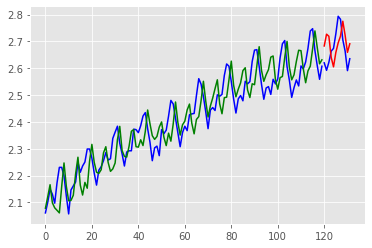

In [34]:
#   График с результатами

#   numpy.arange([start, ]stop, [step, ]dtype=None)

x2 = numpy.arange(0, X_train.shape[0], 1)

x3 = numpy.arange(X_train.shape[0], X_train.shape[0] + X_test.shape[0], 1)


plt.plot(x2, y_train, color='blue')

plt.plot(x2, predictions_train, color='green')

plt.plot(x3, y_test, color='blue')

plt.plot(x3, predictions, color='red')

Переведем предсказания в нормальную шкалу из логарифмической и получим "корректные" с точки зрения размерности числа.

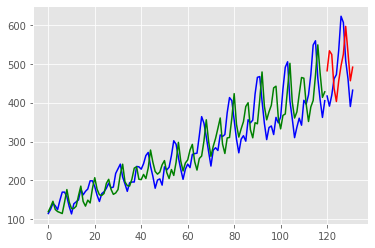

In [35]:
plt.plot(x2, np.power(10, y_train), color='blue')

plt.plot(x2, np.power(10, predictions_train), color='green')

plt.plot(x3, np.power(10, y_test), color='blue')

plt.plot(x3, np.power(10, predictions), color='red')